# Residence Time Distribution Analysis

## Learning Objectives
- Calculate residence time distributions from aquifer pore volume distributions
- Understand the difference between forward and backward residence time perspectives
- Analyze temporal variations in groundwater residence times
- Apply residence time concepts to contaminant transport and water quality assessment

## Overview

This notebook demonstrates how to calculate residence time distributions from aquifer pore volume distributions and flow rates. Residence time quantifies how long water spends in the aquifer, which is crucial for understanding contaminant transport, groundwater vulnerability, and treatment efficiency.

### Applications
- Contaminant transport predictions
- Groundwater vulnerability assessment  
- Treatment efficiency evaluation
- Water quality forecasting
- Well capture zone analysis

### Two Perspectives
- **Forward**: How long until infiltrating water is extracted?
- **Backward**: How long ago was extracted water infiltrated?

### Key Assumptions
- Stationary pore volume distribution
- Advection-dominated transport
- Known aquifer heterogeneity (from Example 1)
- Conservative tracer behavior

## Theoretical Background

### Residence Time Fundamentals

Residence time in groundwater systems represents the travel time of water through the aquifer:

$$t_{residence} = \frac{V_{pore}}{Q} \cdot R_f$$

Where:
- $V_{pore}$: Pore volume along flow path [m³]
- $Q$: Flow rate [m³/day]
- $R_f$: Retardation factor [-] (1.0 for water, >1.0 for reactive tracers)

### Forward vs. Backward Analysis

**Forward Residence Time**: Starting from infiltration time, calculates when water will be extracted
- Used for: Contaminant arrival time predictions
- Question: "When will this contamination reach the well?"

**Backward Residence Time**: Starting from extraction time, calculates when water was infiltrated
- Used for: Source identification and age dating
- Question: "How old is the water we're extracting now?"

### Temporal Variability

Residence times vary over time due to:
- Seasonal flow rate changes
- Aquifer heterogeneity
- Extraction rate variations

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from example_data_generation import generate_synthetic_data

from gwtransport import gamma as gamma_utils
from gwtransport.residence_time import residence_time

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Setup and Aquifer Parameters

We use aquifer parameters typically obtained from Example 1 (temperature-based characterization) and generate flow data for residence time analysis.

In [2]:
# Define aquifer parameters (typically from Example 1 optimization)
mean_pore_volume = 8000.0  # m³
std_pore_volume = 400.0  # m³
retardation_factor = 2.0  # For heat transport comparison
mean_flow = 120.0  # Base discharge rate [m³/day]

# Generate synthetic flow and temperature data
df, tedges = generate_synthetic_data(
    start_date="2020-01-01",
    end_date="2025-12-31",
    mean_flow=mean_flow,
    flow_amplitude=40.0,  # Seasonal variation [m³/day]
    flow_noise=5.0,  # Daily fluctuations [m³/day]
    mean_temp_infiltration=12.0,
    temp_infiltration_amplitude=8.0,
    aquifer_pore_volume=mean_pore_volume,
    aquifer_pore_volume_std=std_pore_volume,
    retardation_factor=retardation_factor,
)

print("Dataset Summary:")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Mean flow: {df['flow'].mean():.1f} m³/day")
print(f"Flow range: {df['flow'].min():.1f} - {df['flow'].max():.1f} m³/day")
print(f"Aquifer parameters: {mean_pore_volume:.0f} ± {std_pore_volume:.0f} m³")

Dataset Summary:
Period: 2020-01-01 to 2025-12-31
Mean flow: 103.0 m³/day
Flow range: 15.3 - 171.5 m³/day
Aquifer parameters: 8000 ± 400 m³


In [3]:
# Discretize pore volume distribution for residence time calculation
n_bins = 1000  # High resolution for accurate calculations
bins = gamma_utils.bins(mean=mean_pore_volume, std=std_pore_volume, n_bins=n_bins)

print(f"Pore volume distribution discretized into {n_bins} bins")
print(f"Bin range: {bins['expected_value'].min():.0f} - {bins['expected_value'].max():.0f} m³")
print(f"Mean residence time (no retardation): {mean_pore_volume / mean_flow:.1f} days")
print(f"Mean residence time (with retardation): {mean_pore_volume / mean_flow * retardation_factor:.1f} days")

Pore volume distribution discretized into 1000 bins
Bin range: 6722 - 9417 m³
Mean residence time (no retardation): 66.7 days
Mean residence time (with retardation): 133.3 days


## 2. Forward Residence Time Analysis

Calculate how long infiltrating water takes to be extracted. We compute residence times for both water flow (conservative tracer) and thermal transport (with retardation).

In [4]:
print("Computing forward residence times...")

# Water residence time (no retardation)
rt_forward_water = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volume=bins["expected_value"],
    retardation_factor=1.0,  # Conservative tracer (water flow)
    direction="infiltration",
)

# Thermal residence time (with retardation)
rt_forward_thermal = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volume=bins["expected_value"],
    retardation_factor=retardation_factor,  # Heat transport (slower)
    direction="infiltration",
)

print(f"Forward residence time arrays shape: {rt_forward_water.shape}")
print(f"({rt_forward_water.shape[0]} flow paths × {rt_forward_water.shape[1]} time steps)")

Computing forward residence times...
Forward residence time arrays shape: (1000, 2192)
(1000 flow paths × 2192 time steps)


In [5]:
# Statistical analysis of residence time distributions
quantiles = [1, 10, 90, 99]  # Percentiles for uncertainty bounds
quantile_headers = [f"rt_forward_water_{q}%" for q in quantiles]

with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message="Mean of empty slice")
    warnings.filterwarnings(action="ignore", message="All-NaN slice encountered")

    # Calculate mean residence times
    df["rt_forward_water_mean"] = np.nanmean(rt_forward_water, axis=0)
    df["rt_forward_thermal_mean"] = np.nanmean(rt_forward_thermal, axis=0)

    # Calculate percentiles for uncertainty analysis
    df[quantile_headers] = np.nanpercentile(rt_forward_water, quantiles, axis=0).T

print("Forward residence time statistics calculated")
print(f"Mean water residence time: {df['rt_forward_water_mean'].mean():.1f} days")
print(f"Mean thermal residence time: {df['rt_forward_thermal_mean'].mean():.1f} days")
print(f"Retardation effect: {df['rt_forward_thermal_mean'].mean() / df['rt_forward_water_mean'].mean():.1f}x")
print(f"({rt_forward_water.shape[0]} flow paths x {rt_forward_water.shape[1]} time steps)")

Forward residence time statistics calculated
Mean water residence time: 80.4 days
Mean thermal residence time: 156.0 days
Retardation effect: 1.9x
(1000 flow paths x 2192 time steps)


## 3. Forward Residence Time Visualization

Visualize how residence times vary over time and compare water vs. thermal transport.

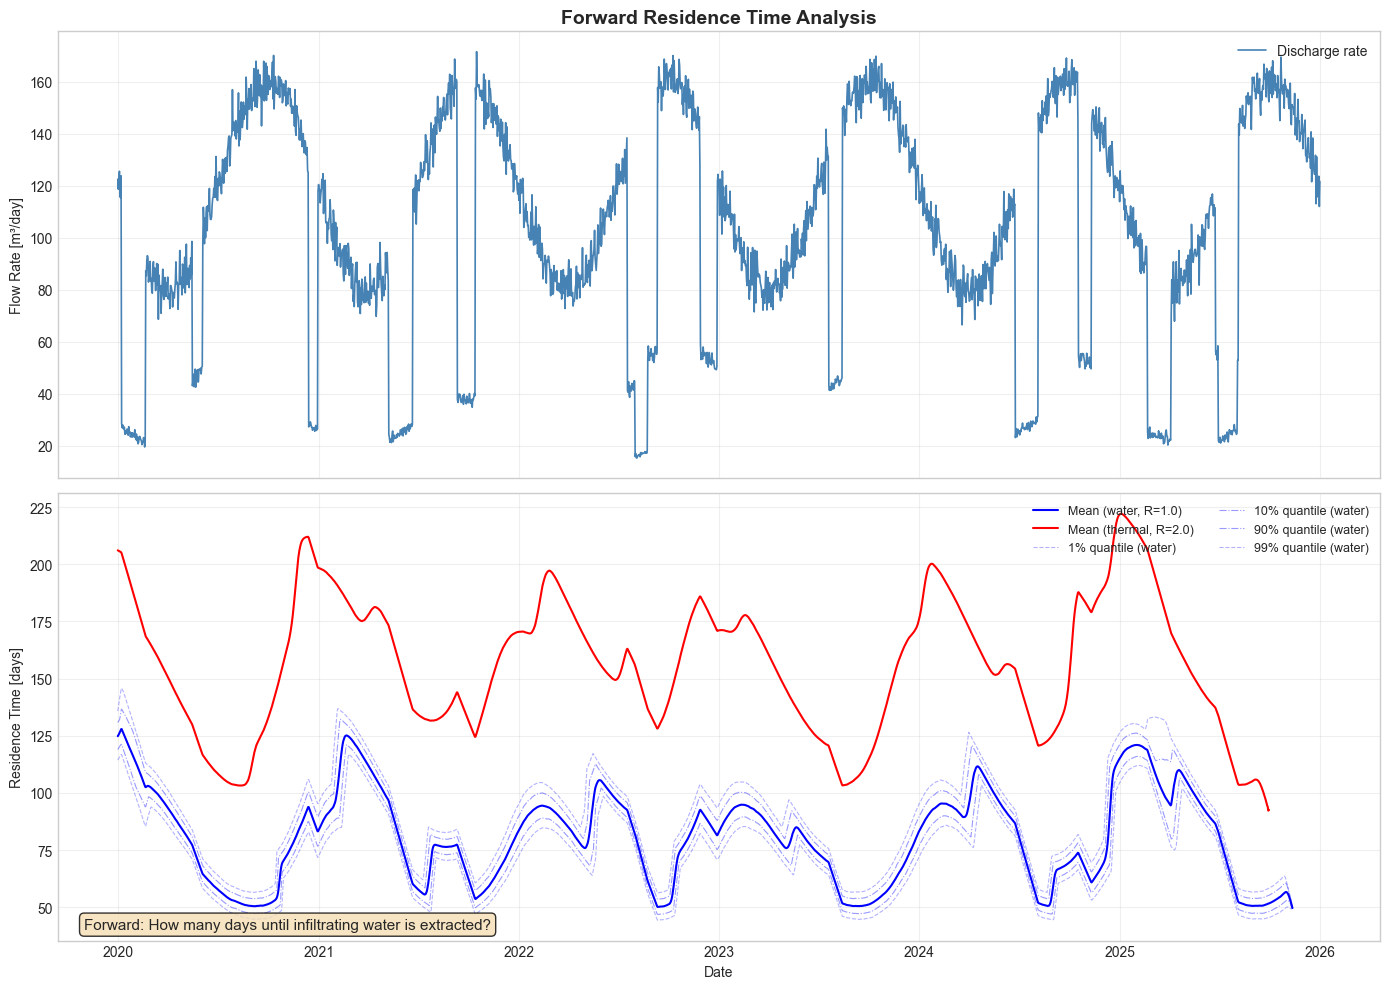

Forward residence time plot saved to: 02_Forward_residence_time.png


In [6]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Flow rate subplot
ax[0].plot(df.index, df.flow, label="Discharge rate", color="steelblue", linewidth=1.2)
ax[0].set_ylabel("Flow Rate [m³/day]")
ax[0].set_title("Forward Residence Time Analysis", fontsize=14, fontweight="bold")
ax[0].legend(loc="upper right")
ax[0].grid(True, alpha=0.3)

# Residence time subplot
ax[1].plot(
    df.index,
    df.rt_forward_water_mean,
    label="Mean (water, R=1.0)",
    color="blue",
    linewidth=1.5,
)
ax[1].plot(
    df.index,
    df.rt_forward_thermal_mean,
    label=f"Mean (thermal, R={retardation_factor:.1f})",
    color="red",
    linewidth=1.5,
)

# Add uncertainty bounds
for q in quantiles:
    alpha_val = 0.4 if q in {10, 90} else 0.3
    linestyle = "--" if q in {1, 99} else "-."
    ax[1].plot(
        df.index,
        df[f"rt_forward_water_{q}%"],
        label=f"{q}% quantile (water)",
        color="blue",
        alpha=alpha_val,
        linewidth=0.8,
        linestyle=linestyle,
    )

ax[1].set_ylabel("Residence Time [days]")
ax[1].set_xlabel("Date")
ax[1].legend(loc="upper right", ncol=2, fontsize=9)
ax[1].grid(True, alpha=0.3)

# Add explanatory text
ax[1].text(
    0.02,
    0.02,
    "Forward: How many days until infiltrating water is extracted?",
    ha="left",
    va="bottom",
    transform=ax[1].transAxes,
    fontsize=11,
    bbox={"boxstyle": "round,pad=0.3", "facecolor": "wheat", "alpha": 0.8},
)

plt.tight_layout()

# Save the forward residence time plot
out_path = Path("02_Forward_residence_time.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Forward residence time plot saved to: {out_path}")

## 4. Backward Residence Time Analysis

Calculate when currently extracted water was originally infiltrated. This perspective is crucial for source identification and age dating.

In [7]:
print("Computing backward residence times...")

# Water residence time (no retardation)
rt_backward_water = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volume=bins["expected_value"],
    retardation_factor=1.0,
    direction="extraction",
)

# Thermal residence time (with retardation)
rt_backward_thermal = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volume=bins["expected_value"],
    retardation_factor=retardation_factor,
    direction="extraction",
)

print(f"Backward residence time arrays shape: {rt_backward_water.shape}")

Computing backward residence times...
Backward residence time arrays shape: (1000, 2192)


In [8]:
# Statistical analysis for backward residence times
quantile_headers_backward = [f"rt_backward_water_{q}%" for q in quantiles]

with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message="Mean of empty slice")
    warnings.filterwarnings(action="ignore", message="All-NaN slice encountered")

    # Calculate mean residence times
    df["rt_backward_water_mean"] = np.nanmean(rt_backward_water, axis=0)
    df["rt_backward_thermal_mean"] = np.nanmean(rt_backward_thermal, axis=0)

    # Calculate percentiles
    df[quantile_headers_backward] = np.nanpercentile(rt_backward_water, quantiles, axis=0).T

print("Backward residence time statistics calculated")
print(f"Mean backward water residence time: {df['rt_backward_water_mean'].mean():.1f} days")
print(f"Mean backward thermal residence time: {df['rt_backward_thermal_mean'].mean():.1f} days")

Backward residence time statistics calculated
Mean backward water residence time: 80.4 days
Mean backward thermal residence time: 156.8 days


## 5. Backward Residence Time Visualization

Show how the age of extracted water varies over time, revealing the temporal dynamics of groundwater flow.

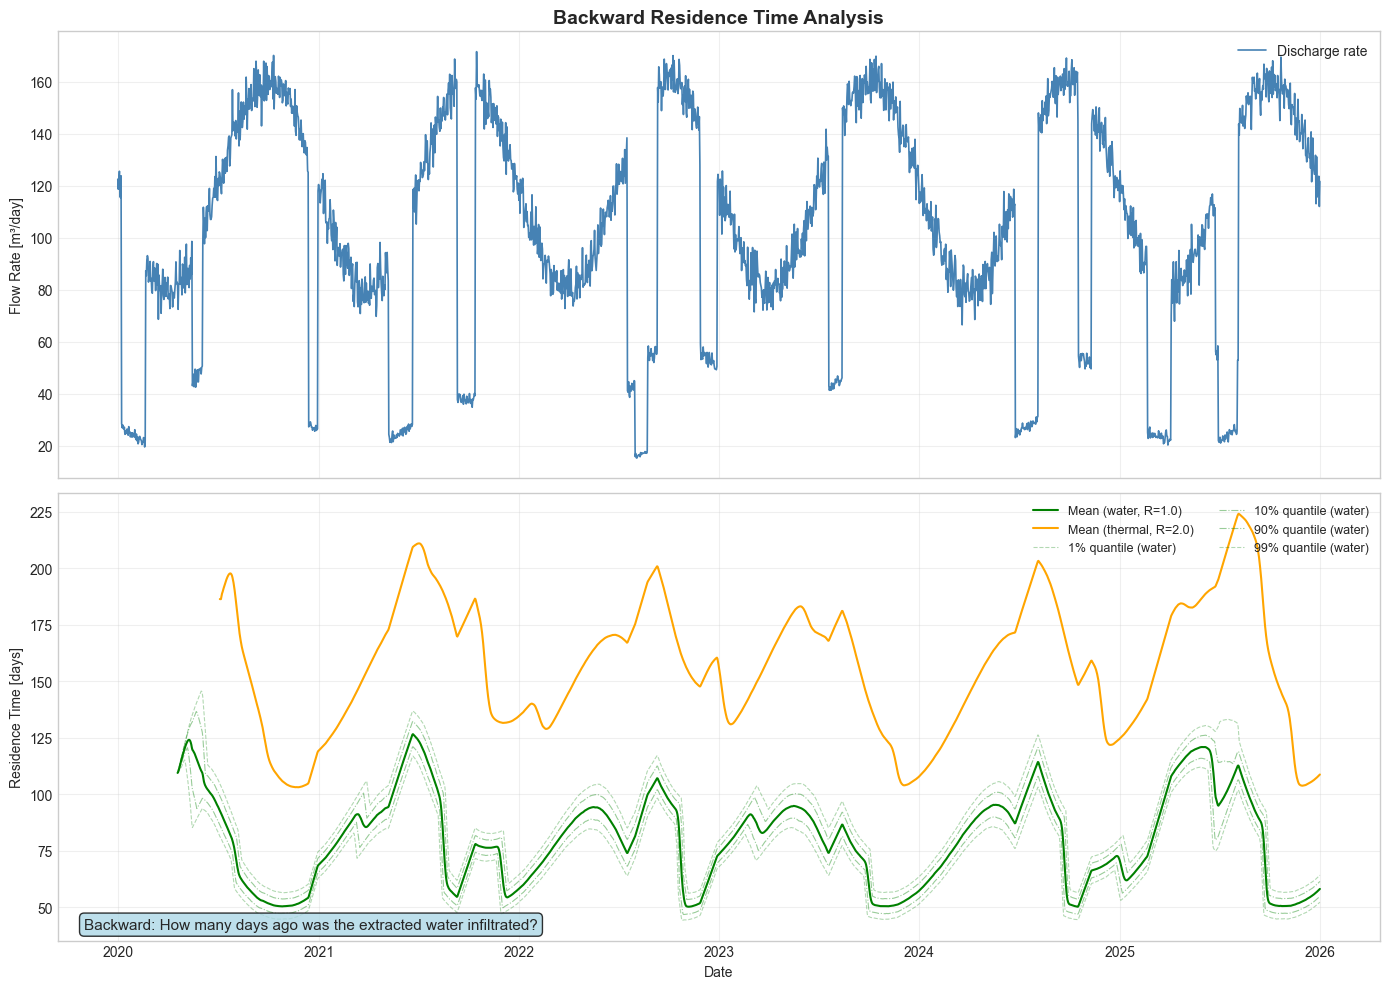

Backward residence time plot saved to: 02_Backward_residence_time.png


In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Flow rate subplot
ax[0].plot(df.index, df.flow, label="Discharge rate", color="steelblue", linewidth=1.2)
ax[0].set_ylabel("Flow Rate [m³/day]")
ax[0].set_title("Backward Residence Time Analysis", fontsize=14, fontweight="bold")
ax[0].legend(loc="upper right")
ax[0].grid(True, alpha=0.3)

# Residence time subplot
ax[1].plot(
    df.index,
    df.rt_backward_water_mean,
    label="Mean (water, R=1.0)",
    color="green",
    linewidth=1.5,
)
ax[1].plot(
    df.index,
    df.rt_backward_thermal_mean,
    label=f"Mean (thermal, R={retardation_factor:.1f})",
    color="orange",
    linewidth=1.5,
)

# Add uncertainty bounds for water
for q in quantiles:
    alpha_val = 0.4 if q in {10, 90} else 0.3
    linestyle = "--" if q in {1, 99} else "-."
    ax[1].plot(
        df.index,
        df[f"rt_backward_water_{q}%"],
        label=f"{q}% quantile (water)",
        color="green",
        alpha=alpha_val,
        linewidth=0.8,
        linestyle=linestyle,
    )

ax[1].set_ylabel("Residence Time [days]")
ax[1].set_xlabel("Date")
ax[1].legend(loc="upper right", ncol=2, fontsize=9)
ax[1].grid(True, alpha=0.3)

# Add explanatory text
ax[1].text(
    0.02,
    0.02,
    "Backward: How many days ago was the extracted water infiltrated?",
    ha="left",
    va="bottom",
    transform=ax[1].transAxes,
    fontsize=11,
    bbox={"boxstyle": "round,pad=0.3", "facecolor": "lightblue", "alpha": 0.8},
)

plt.tight_layout()

# Save the backward residence time plot
out_path = Path("02_Backward_residence_time.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Backward residence time plot saved to: {out_path}")

## 6. Comparative Analysis

Compare forward and backward residence times to understand their differences and applications.

In [10]:
# Calculate comparison statistics
print("Comparative Analysis: Forward vs. Backward Residence Times")
print("=" * 65)

# Mean values
forward_mean = df["rt_forward_water_mean"].mean()
backward_mean = df["rt_backward_water_mean"].mean()
print("Mean residence times:")
print(f"  Forward (water):  {forward_mean:.1f} days")
print(f"  Backward (water): {backward_mean:.1f} days")
print(f"  Difference:       {abs(forward_mean - backward_mean):.1f} days")

# Variability
forward_std = df["rt_forward_water_mean"].std()
backward_std = df["rt_backward_water_mean"].std()
print("\nTemporal variability (standard deviation):")
print(f"  Forward (water):  {forward_std:.1f} days")
print(f"  Backward (water): {backward_std:.1f} days")

# Retardation effects
thermal_ratio_forward = df["rt_forward_thermal_mean"].mean() / forward_mean
thermal_ratio_backward = df["rt_backward_thermal_mean"].mean() / backward_mean
print("\nRetardation effects (thermal/water ratio):")
print(f"  Forward:  {thermal_ratio_forward:.2f}")
print(f"  Backward: {thermal_ratio_backward:.2f}")

# Flow rate correlation
flow_rt_corr_forward = np.corrcoef(df["flow"], df["rt_forward_water_mean"])[0, 1]
flow_rt_corr_backward = np.corrcoef(df["flow"], df["rt_backward_water_mean"])[0, 1]
print("\nCorrelation with flow rate:")
print(f"  Forward:  {flow_rt_corr_forward:.3f}")
print(f"  Backward: {flow_rt_corr_backward:.3f}")
print("\nNote: Negative correlation indicates shorter residence times at higher flows")

Comparative Analysis: Forward vs. Backward Residence Times
Mean residence times:
  Forward (water):  80.4 days
  Backward (water): 80.4 days
  Difference:       0.0 days

Temporal variability (standard deviation):
  Forward (water):  20.3 days
  Backward (water): 20.3 days

Retardation effects (thermal/water ratio):
  Forward:  1.94
  Backward: 1.95

Correlation with flow rate:
  Forward:  nan
  Backward: nan

Note: Negative correlation indicates shorter residence times at higher flows


## Results & Discussion

### Flow Rate Dependencies
Residence times show strong inverse correlation with flow rates:
- **High flows**: Shorter residence times, faster transport
- **Low flows**: Longer residence times, more retention

### Forward vs. Backward Perspectives
- **Similar mean values**: Both perspectives yield comparable average residence times
- **Different temporal patterns**: Timing of variability differs due to flow history effects
- **Practical applications**: Choose perspective based on specific management question

### Retardation Effects
Thermal retardation factor of 2.0 effectively doubles residence times:
- Important for temperature-based tracer studies
- Affects timing of thermal breakthrough
- Must be considered in heat transport applications

### Engineering Applications

**Contaminant Transport**:
- Use forward analysis for spill response planning
- Use backward analysis for source identification

**Well Field Design**:
- Optimize pumping rates based on residence time requirements
- Consider seasonal flow variations in planning

**Water Quality Management**:
- Predict arrival times of contaminants
- Assess natural attenuation potential
- Design monitoring networks

## Key Takeaways

✅ **Two Perspectives**: Forward and backward residence times answer different but complementary questions

✅ **Flow Rate Control**: Higher flows lead to shorter residence times and faster transport

✅ **Temporal Variability**: Residence times vary seasonally due to flow rate changes

✅ **Retardation Effects**: Must account for tracer-specific retardation in transport analysis

✅ **Uncertainty Quantification**: Use percentile analysis to capture aquifer heterogeneity effects

✅ **Practical Applications**: Choose analysis perspective based on specific management objectives

## Further Reading

- **Previous Example**: Aquifer Characterization using Temperature (Example 1)
- **Next Example**: Pathogen Removal in Bank Filtration (Example 3)
- **Advanced Topics**: Age dating methods, tritium analysis, residence time modeling

### References
- McCallum, J.L., Cook, P.G., Brunner, P., & Burd, K. (2010). Solute transport along stream networks. *Journal of Hydrology*, 389(1-2), 214-226.
- Goode, D.J. (1996). Direct simulation of groundwater age. *Water Resources Research*, 32(2), 289-296.
- Varni, M., & Carrera, J. (1998). Simulation of groundwater age distributions. *Water Resources Research*, 34(12), 3271-3281.